In [1]:
#Import Library
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
#unzip dataset
import zipfile

local_zip = 'C:/Users/ASUS/OneDrive/ML Bangkit/dogSkinDisease.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/data')
zip_ref.close()

In [3]:
#check the number of image per class
os.listdir('/tmp/data')

#number of images of each classes in the training_set folder
print(f"There are {len(os.listdir('/tmp/data/train/flea_allergy'))} train set images of flea allergy.")
print(f"There are {len(os.listdir('/tmp/data/train/hotspot'))} train set images of hotspot.")
print(f"There are {len(os.listdir('/tmp/data/train/mange'))} train set images of mange.")
print(f"There are {len(os.listdir('/tmp/data/train/ringworm'))} train set images of ringworm.")
print()

#now return the list of the content in that validation_set folder
print(f"There are {len(os.listdir('/tmp/data/validation/flea_allergy'))} val set images of flea allergy.")
print(f"There are {len(os.listdir('/tmp/data/validation/hotspot'))} val set images of hotspot.")
print(f"There are {len(os.listdir('/tmp/data/validation/mange'))} val set images of mange.")
print(f"There are {len(os.listdir('/tmp/data/validation/ringworm'))} val set images of ringworm.")
print()

#now return the list of the content in that testing_set folder
print(f"There are {len(os.listdir('/tmp/data/test/flea_allergy'))} test set images of flea allergy.")
print(f"There are {len(os.listdir('/tmp/data/test/hotspot'))} test set images of hotspot.")
print(f"There are {len(os.listdir('/tmp/data/test/mange'))} test set images of mange.")
print(f"There are {len(os.listdir('/tmp/data/test/ringworm'))} test set images of ringworm.")

There are 76 train set images of flea allergy.
There are 96 train set images of hotspot.
There are 63 train set images of mange.
There are 138 train set images of ringworm.

There are 20 val set images of flea allergy.
There are 20 val set images of hotspot.
There are 20 val set images of mange.
There are 20 val set images of ringworm.

There are 20 test set images of flea allergy.
There are 20 test set images of hotspot.
There are 20 test set images of mange.
There are 20 test set images of ringworm.


In [4]:
#make directory
TRAINING_DIR = "/tmp/data/train"
VALIDATION_DIR = "/tmp/data/validation"
TESTING_DIR = "/tmp/data/testing"

TRAINING_FLEA_DIR = "/tmp/data/train/flea_allergy"
VALIDATION_FLEA_DIR = "/tmp/data/validation/flea_allergy"
TEST_FLEA_DIR = "/tmp/data/testing/flea_allergy"

TRAINING_HOTSPOT_DIR = "/tmp/data/train/hotspot"
VALIDATION_HOTSPOT_DIR = "/tmp/data/validation/hotspot"
TESTING_HOTSPOT_DIR = "/tmp/data/testing/hotspot"

TRAINING_MANGE_DIR = "/tmp/data/train/mange"
VALIDATION_MANGE_DIR = "/tmp/data/validation/mange"
TESTING_MANGE_DIR = "/tmp/data/testing/mange"

TRAINING_RINGWORM_DIR = "/tmp/data/train/ringworm"
VALIDATION_RINGWORM_DIR = "/tmp/data/validation/ringworm"
TESTING_RINGWORM_DIR = "/tmp/data/testing/ringworm"

In [5]:
#generate image to augment the image
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                     fill_mode='nearest',
                                     rotation_range=45,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.1,
                                     zoom_range=0.1,
                                     horizontal_flip=True,
                                     )

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=128,
                                                      class_mode='categorical',
                                                      target_size=(100, 100))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale = 1.0 / 255. )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=128,
                                                                class_mode='categorical',
                                                                target_size=(100, 100))
  ### END CODE HERE
  return train_generator, validation_generator

In [6]:
#apply function
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 373 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [7]:
#function for show image
def show_image_samples(gen):
  train_dict = train_generator.class_indices
  classes = list(train_dict.keys())
  images, labels = next(gen) #get a sample batch from generator
  plt.figure(figsize=(20,20))
  length = len(labels)
  if length < 10:
    r = length
  else:
    r = 10
  for i in range(r):
    plt.subplot(5, 5, i+1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='black', fontsize=18)
    plt.axis('off')
  plt.show()

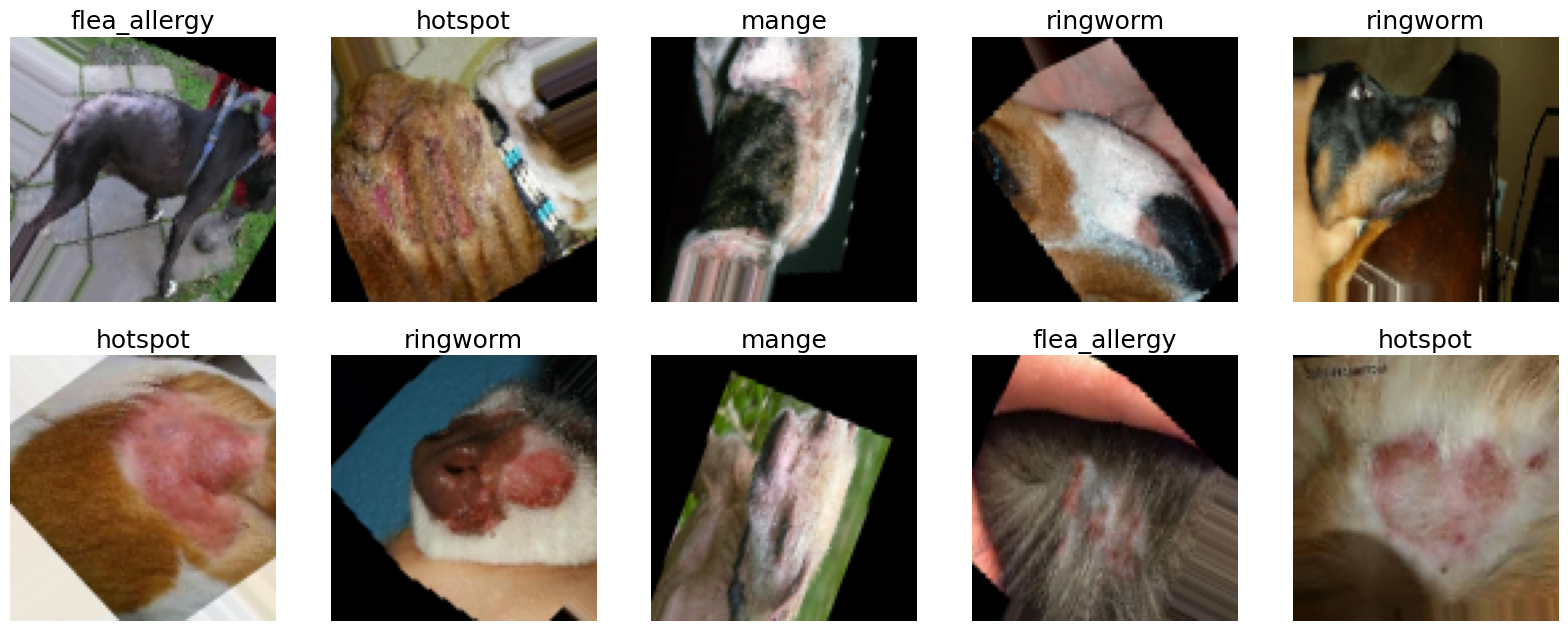

In [8]:
#apply function to train dataset
show_image_samples(train_generator)

In [20]:
#resize image
IMAGE_SIZE = [100, 100]

#use InceptionV3 (Transfer Learning) to build model 
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False
    
model = tf.keras.models.Sequential([
    inception,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1028, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
#def create_model():
   # model = tf.keras.models.Sequential([
       # tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(100, 100, 3)),
       # tf.keras.layers.BatchNormalization(),
       # tf.keras.layers.MaxPooling2D(2,2),
       # tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
       # tf.keras.layers.BatchNormalization(),
       # tf.keras.layers.MaxPooling2D(2,2),
       # tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
       # tf.keras.layers.BatchNormalization(),
       # tf.keras.layers.MaxPooling2D(2,2),
       # tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
       # tf.keras.layers.BatchNormalization(),
       # tf.keras.layers.GlobalAveragePooling2D(),  # Mengubah tensor 4D menjadi tensor 2D
       # tf.keras.layers.Dense(128, activation='relu'),
       # tf.keras.layers.Dropout(0.5),
       # tf.keras.layers.Dense(32, activation='relu'),
       # tf.keras.layers.Dense(4, activation='softmax')
    ])

    #model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']) 

   # return model

# Verifikasi ukuran input
#model = create_model()
#model.summary()

In [26]:
#compile model
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [27]:
EPOCHS = 25

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=25,  
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=25)

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 510ms/step - accuracy: 0.6007 - loss: 3.5662 - val_accuracy: 0.4000 - val_loss: 5.2730
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 320ms/step - accuracy: 0.5194 - loss: 2.5783 - val_accuracy: 0.8250 - val_loss: 0.5064
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - accuracy: 0.7922 - loss: 0.5406 - val_accuracy: 0.8500 - val_loss: 0.4179
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 511ms/step - accuracy: 0.8461 - loss: 0.4223 - val_accuracy: 0.8625 - val_loss: 0.3990
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - accuracy: 0.8612 - loss: 0.3873 - val_accuracy: 0.7750 - val_loss: 0.5114
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 627ms/step - accuracy: 0.7595 - loss: 0.6612 - val_accuracy: 0.7750 - val_loss: 0.5681
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 636ms/step - accuracy: 0.6625 - loss: 0.8462 - val_accuracy: 0.8750 - val_loss: 0.3460
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 350ms/step - accuracy: 0.8500 - loss: 0.3913 - val_accu

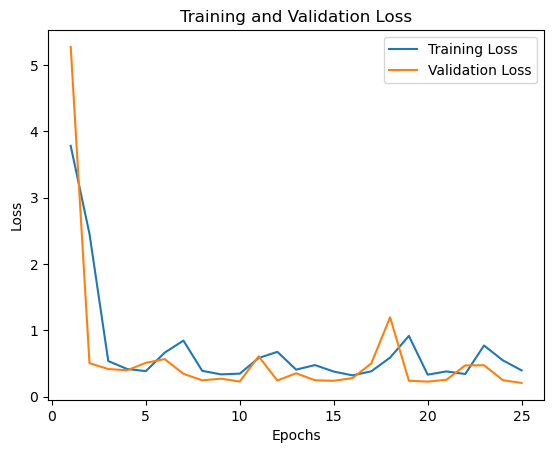

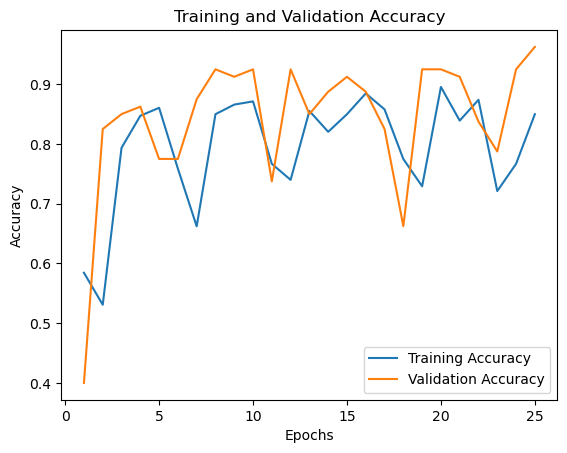

In [28]:
#make loss and accuracy plot for make decision
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot loss
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()